## Set up libraries and load exemplar dataset

In [69]:
# load libraries
import os
import whitenoise
import whitenoise.components as op
import numpy as np
import math

# establish data information
data_path = os.path.join('..', 'data', 'PUMS_california_demographics_1000', 'data.csv')
var_names = ["age", "sex", "educ", "race", "income", "married"]

data = np.genfromtxt(data_path, delimiter=',', names=True)
age = list(data[:]['age'])

print("Dimension of dataset: " + str(data.shape))
print("Names of variables:   " + str(data.dtype.names))

Dimension of dataset: (1000,)
Names of variables:   ('age', 'sex', 'educ', 'race', 'income', 'married')


## Construct a loglinear sequence of parameters to run repeated simulations over, to demonstrate utility

In [70]:
n_sims = 100
def logsequence(start, stop, num, base=10, decimals=2, asint=False):
    my_seq = np.linspace(start=math.log10(start), stop=math.log10(stop), num=num)
    my_seq = np.power(10, my_seq)
    if asint:
        my_seq = list(my_seq.round().astype(int))
    else:
        my_seq = my_seq.round(decimals=decimals)
    return my_seq

n_seq = logsequence(start=200, stop=1500, num=10, asint=True)
epsilon_seq = logsequence(start=1, stop=0.01, num=4, decimals=2)

print("Sequence of dataset sizes:  " + str(n_seq))
print("Sequence of epsilon values: " + str(epsilon_seq))

Sequence of dataset sizes:  [200, 250, 313, 391, 490, 613, 766, 959, 1199, 1500]
Sequence of epsilon values: [1.   0.22 0.05 0.01]


## Bootstrap the data and generate DP releases over different dataset sizes and values of epsilon

In [71]:
rawhistory = np.zeros(shape=(len(n_seq)*len(epsilon_seq)*n_sims, 4), dtype=float)
agghistory = np.zeros(shape=(len(n_seq)*len(epsilon_seq), 3), dtype=float)

temp_data_path = os.path.join('..', 'data', 'PUMS_california_demographics_1000', 'temp.csv')

rawcount = -1
aggcount = -1

for i in n_seq:
    for j in epsilon_seq:
        aggcount += 1
        error = [0] * n_sims
        for k in range(n_sims):
            rawcount += 1
            
            # Mean release
            tempdata = np.random.choice(a=age, size=i)
            np.savetxt(fname=temp_data_path, X=tempdata, delimiter=',', header='age', comments="")
            
            
            with whitenoise.Analysis() as analysis:
                # load data
                data = whitenoise.Dataset(path = temp_data_path, column_names = ["age"])

                # get mean of age
                age_mean = op.dp_mean(data = op.cast(data['age'], type="FLOAT"),
                          privacy_usage = {'epsilon': j},
                          data_min = 0.,
                          data_max = 100.,
                          data_n = i
                         )
            analysis.release()
            
            release = age_mean.value
            sample_truth = tempdata.mean()
            error[k] = sample_truth - release
     
            rawhistory[rawcount, 0] = i
            rawhistory[rawcount, 1] = j
            rawhistory[rawcount, 2] = release
            rawhistory[rawcount, 3] = sample_truth
        
        agghistory[aggcount, 0] = i
        agghistory[aggcount, 1] = j
        agghistory[aggcount, 2] = math.sqrt(np.power(error,2).mean())

        
print("Example simulations: \n")
print(agghistory[0:5])  

Example simulations: 

[[2.00000000e+02 1.00000000e+00 6.51760563e-01]
 [2.00000000e+02 2.20000000e-01 2.75263452e+00]
 [2.00000000e+02 5.00000000e-02 1.22234085e+01]
 [2.00000000e+02 1.00000000e-02 7.13851069e+01]
 [2.50000000e+02 1.00000000e+00 5.22801997e-01]]


## Plot the simulations of error against sample size for different epsilon values

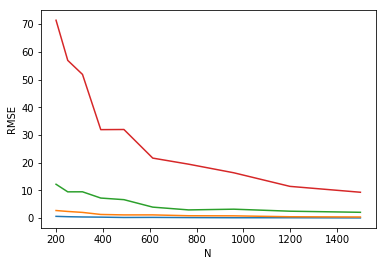

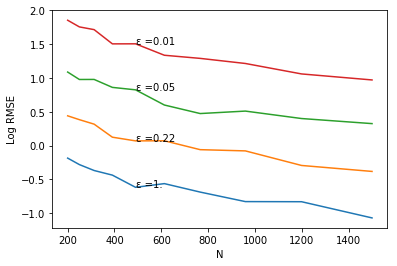

In [72]:
import matplotlib
import matplotlib.pyplot as plt

for epsilon in epsilon_seq:
    flag = agghistory[:,1] == epsilon
    plt.plot(agghistory[flag, 0], agghistory[flag, 2]) 
  
plt.ylabel('RMSE')
plt.xlabel('N')
plt.show()

xloc = round(len(n_seq)*0.4)
for epsilon in epsilon_seq:
    flag = agghistory[:,1] == epsilon
    subhistory = agghistory[flag,:]
    plt.plot(subhistory[:, 0], np.log10(subhistory[:, 2])) 
    #text(x=subhistory[xloc,1], y=subhistory[xloc,3], label=  bquote(paste(epsilon == .(ep.seq[j]))), col=color.palette[j], pos=4)
    plt.text(x=subhistory[xloc,0] , y=np.log10(subhistory[xloc,2]), s="\u03B5 =" + np.array2string(subhistory[0,1]) )
    
plt.ylabel('Log RMSE')
plt.xlabel('N')
plt.show()